# Exercise 1

Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net.

Evaluate the loss; 
Did it improve over a bigram model?

## 1.1 Statistic model

In [1]:
words = open('names.txt','r').read().splitlines()

In [2]:
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# map  bigram to char
t = {}
for w in words:
    chs = ['.']+ list(w)+['.']
    for bi,ch in zip(zip(chs,chs[1:]),chs[2:]):
        trigram = (bi,ch)
        t[trigram] = t.get(trigram,0)+1
#         print(ch1,ch2)

In [4]:
import torch

In [5]:
#make bigramss
bigrams_maker = map(lambda x: x[0],t.keys())
bigrams_not_sorted = list((bigrams_maker))
bigrams = sorted(list(set(bigrams_not_sorted)), key = lambda kv: kv)

In [6]:
# chars/bigrams to number and vice versa
# chars
chars = sorted(list(set(''.join(words))))
ctoi = {s:i+1 for i,s in enumerate(chars)} # character to integer
ctoi['.']=0
itoc = {i:s for s,i in ctoi.items()} # integer to chatacter
#bigrams
btoi = {}
itob = {}
number = 0
chars_dot = sorted(list(ctoi.keys()))
for s1 in chars_dot:
    for s2 in chars_dot:
        btoi[s1+s2]=number
        itob[number] =s1+s2
        number+=1

In [7]:
#fill statistic matrix
N = torch.zeros((len(btoi.keys()),27), dtype= torch.int32)

for w in words:
    chs = ['.']+ list(w)+['.']
    for bi,ch in zip(zip(chs,chs[1:]),chs[2:]):
#         trigram = (bi,ch)
#         print(bi)
        bi = f'{bi[0]}{bi[1]}'
#         print(bi)
        ix1 = btoi[bi]
        ix2 = ctoi[ch]
        N[ix1,ix2]+=1


In [8]:
# create probability matrix
# N+1 in case to not zeros probs when using nll
P = (N+1).float()
P /=P.sum(1,keepdim =True)

In [9]:
print(N[10,3]) # first - bigram number, second - char number

tensor(3, dtype=torch.int32)


In [10]:
# to predict names, we shoud make statistic of first two characters, starting with dot
P_first = torch.zeros((26),dtype= torch.int32)
for ch1,ch2 in bigrams_not_sorted:
    if ctoi[ch1]==0:
#         print(ch1,ch2)
        num = ctoi[ch2]
        P_first[num-1] +=1

In [11]:
# create probability vector
P_first = P_first.float()
P_first /=P_first.sum()

In [12]:
# Fancy checking
i = 2
j = 1
print(itob[i])
print(f'Probability for bigram [{itob[i]}] followed by character [{itoc[j]}] is {P[i,j]}')

.b
Probability for bigram [.b] followed by character [a] is 0.12753188610076904


In [13]:
g_first = torch.Generator().manual_seed(2148483647)
g = torch.Generator().manual_seed(2147983647)

In [14]:
# name generator with stat model
for i in range(20):
    out = []
    ix = 0
    while True:
        if not out:
            p = P_first
            ix = 0
            # we don't need .. starting point
            while ix==0:
                ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g_first).item()
            out.append(itob[ix])
            ix = ix 
        else:
            p = P[ix]
            #getting last char
            prev_char = itob[ix][1:2]
            #generate next char
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
           #current char
            cur_char = itoc[ix]
            out.append(cur_char)
            # check if it's dot
            if ix==0:
                break
            #create next ix  (take second char of last bigramc 'prev_char' and concat with current 'cur_char')
            ix = btoi[prev_char+cur_char]
        if ix == 0:
            break
            
    print(''.join(out))

.ca.
.jachalqqpvaliyontlen.
.wattelis.
.vtklpmfortiri.
.yalestyhqgh.
.robirayven.
.eiros.
.hourdqjrx.
.lah.
.ia.
.teone.
.jamin.
.kanvioan.
.marlyner.
.denii.
.belia.
.dakyraylie.
.pheth.
.bjarismah.
.ho.


In [15]:
#calculate negative log-likelihood
# log(abc) = log(a)+log(b)+log(c)
log_likekihood = 0.0
n=0

for w in words:
    chs = ['.']+ list(w)+['.']
    for bi,ch in zip(zip(chs,chs[1:]),chs[2:]):
        bx1 = btoi[bi[0]+bi[1]]
        ix2 = ctoi[ch]
        prob = P[bx1,ix2]
        logprob = torch.log(prob)
        log_likekihood+=logprob
        n+=1

print(f'{log_likekihood=}')
nll = -log_likekihood
print(f'{nll=}')
print(f'{nll/n}')

log_likekihood=tensor(-410414.9688)
nll=tensor(410414.9688)
2.092747449874878


## 1.1 Simple trigram 'net'

In [16]:
#regularizations
regs = {}

regs['L1'] = lambda x, lamb: lamb*(x).mean()
regs['L2'] = lambda x, lamb: lamb*(x**2).mean()
regs['ElasticNet'] = lambda x, lamb: regs['L1'](x, lamb) + regs['L2'](x, lamb)

In [17]:
#create model class
from math import pow
import torch.nn.functional as F

class Net():
    def __init__(self, ngrams,gen = None, bias = False,lr = 50, regul = 'L2', lamb = 0.01, name = "model"):
        self.ngrams = int(pow(27,ngrams))
        self.out = 27
        self.lr = lr
        self.lamb = lamb
        self.reg = regs[regul]
        self.name = name
        
        if not gen:
            self.gen = torch.Generator().manual_seed(2148483647)
        else:
            self.gen = gen    
        self.W = torch.randn((self.ngrams, self.out), generator= self.gen, requires_grad=True)
        self.bias = bias
        if bias:
            self.b = torch.randn((self.out), generator = self.gen, requires_grad=True)
            
    def train(self, xs, ys, steps=100):
        for k in range(steps):
  
            # forward pass
            xenc = F.one_hot(xs, self.ngrams).float() # input to the network: one-hot encoding
            if self.bias:
                logits = xenc @ self.W + self.b # predict log-counts x*w+b
            else:
                logits = xenc @ self.W # x*w
            counts = logits.exp() # counts, equivalent to N
            probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
            loss = -probs[torch.arange(xs.nelement()), ys].log().mean() + self.reg(self.W, self.lamb)

            # backward pass
            self.W.grad = None # set to zero the gradient
            loss.backward()

            # update
            self.W.data += -self.lr * self.W.grad
            
        return logits, loss.item()
            
    def evaluate(self,xs,ys):
        xenc = F.one_hot(xs, self.ngrams).float() # input to the network: one-hot encoding
        if self.bias:
                logits = xenc @ self.W + self.b # predict log-counts x*w+b
        else:
                logits = xenc @ self.W # x*w
        counts = logits.exp() # counts, equivalent to N
        probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
        
        loss = -probs[torch.arange(xs.nelement()), ys].log().mean() + self.reg(self.W, self.lamb)
        return loss.item()
        
    def generate(self,number=10):
        # finally, sample from the 'neural net' model
        outs = []
        for i in range(number):
            out = []
            ix = 0
            while True:
                if not out:
                    p = P_first
                    ix = 0
                    # we don't need [..] bigram as starting point
                    while ix==0:
                        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=self.gen).item()
                    out.append(itob[ix])
                    ix = ix
                else:
                    #---------
                    # BEFORE:
                    #p = P[ix]
                    #---------
                    # NOW:
                    xenc = F.one_hot(torch.tensor([ix]),self.ngrams).float()
                    logits = xenc @ self.W # predict log-counts
                    counts = logits.exp() # counts, equivalent to N
                    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
                    #---------
                    #getting last char
                    prev_char = itob[ix][-1]
                    #generate next char
                    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=self.gen).item()
                    #current char
                    cur_char = itoc[ix]
                    out.append(cur_char)
                    # check if it's dot
                    if ix==0:
                        break
                    #create next ix  (take second char of last bigramc 'prev_char' and concat with current 'cur_char')
                    ix = btoi[prev_char+cur_char]
                if ix == 0:
                    break

            outs.append(''.join(out))
        return outs
            

In [18]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for bi,ch in zip(zip(chs,chs[1:]),chs[2:]):
        bx1 = btoi[bi[0]+bi[1]]
        ix2 = ctoi[ch]
        xs.append(bx1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

number of examples:  196113


In [19]:
nn = Net(ngrams=2)

In [20]:
nn.train(xs,ys,500)

(tensor([[-1.6748, -0.0565, -0.3471,  ..., -1.0068,  0.1063,  0.9243],
         [ 2.7980,  2.8903,  1.0213,  ..., -1.4817,  1.1807, -0.4645],
         [-0.0521,  3.2333,  0.1094,  ..., -1.2024,  0.4162, -1.4900],
         ...,
         [ 1.6560,  1.6288, -0.1112,  ..., -1.0540, -0.8530, -0.0147],
         [-0.7512,  1.9500,  1.4730,  ...,  0.0272, -0.3875,  1.0157],
         [ 1.6579,  1.5247,  0.1407,  ..., -1.0709, -0.3184, -0.5341]],
        grad_fn=<MmBackward0>),
 2.167802095413208)

In [21]:
for name in nn.generate():
    print(name)

.fcpjlann.
.tiellyn.
.huocryxfxw.
.yandinellyn.
.chqrsomiquefxfbwcsqtjuhavcswctch.
.ta.
.hasir.
.braystephgbpcveshoey.
.cadia.
.graxbrin.


In [22]:
print(nn.evaluate(xs,ys))

2.1676483154296875


## Conlcusion 

Loss became smaller due to expanded information used to predict next character (2 characters used instead of 1)

# Exercise 2

Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. 

Evaluate them on dev and test splits. What can you see?

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for bi,ch in zip(zip(chs,chs[1:]),chs[2:]):
        bx1 = btoi[bi[0]+bi[1]]
        ix2 = ctoi[ch]
        xs.append(bx1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

# split to train/dev/test
X_train,X_dev,y_train,y_dev = train_test_split(xs, ys, test_size=0.1)
X_train,X_test,y_train,y_test = train_test_split(X_train, y_train, test_size=0.1111, random_state=2023)
print(f'X_train size: {X_train.size(dim=0)}, y_train size: {y_train.size(dim=0)}')
print(f'X_dev size: {X_dev.size(dim=0)}, y_dev size: {y_dev.size(dim=0)}')
print(f'X_test size: {X_test.size(dim=0)}, y_test size: {y_test.size(dim=0)}')

X_train size: 156891, y_train size: 156891
X_dev size: 19612, y_dev size: 19612
X_test size: 19610, y_test size: 19610


In [25]:
nn = Net(2)

In [26]:
nn.train(X_train, y_train, 500)

(tensor([[-0.9302,  5.4039, -0.8159,  ..., -0.8756,  2.6719, -1.1904],
         [ 3.5665,  2.7136, -0.5573,  ..., -1.3525,  2.8615, -0.9304],
         [ 1.4338,  1.9930, -0.1504,  ..., -0.9458,  0.9148, -0.1160],
         ...,
         [ 3.8636, -0.4589, -0.9401,  ..., -1.8879, -0.8645, -1.7151],
         [ 4.1966,  0.7146, -0.9083,  ..., -1.2519, -0.8284, -0.5964],
         [ 2.2674,  2.3368, -1.0581,  ..., -0.4648,  1.0905, -0.8874]],
        grad_fn=<MmBackward0>),
 2.1643447875976562)

In [27]:
train_loss = nn.evaluate(X_train, y_train)
dev_loss = nn.evaluate(X_dev, y_dev)
test_loss = nn.evaluate(X_test, y_test)
print(f'Loss on train set is {dev_loss}')
print(f'Loss on dev set is {dev_loss}')
print(f'Loss on test set is {test_loss}')

Loss on train set is 2.1794252395629883
Loss on dev set is 2.1794252395629883
Loss on test set is 2.2008564472198486


In [28]:
for names in nn.generate():
    print(names)

.fen.
.jarrevellizailyn.
.ruzjus.
.yandinellyn.
.chrimickiqljye.
.sanie.
.sabramper.
.jaya.
.hasir.
.braystephi.


Loss on dev and test sets a bit larges then on train set. The distribution of trigrams quite close in all datasets.

# Exercise 3

Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. 

What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [29]:
# thoughts:
# - add bias (need more learning and achieving better result)
# - change lambda 
# -  add Elastic Net(l1+l2) (ElasticNet slightly better)
# - change learning rate (changing every 1k steps)
# - add batch (not needed, we procced all input by operation (Len(input), 729) @ (729, 27) )

## 3.1 With vs Without bias

In [30]:
# with bias
nn_wb = Net(ngrams=2,bias=True, name = 'nn_wb')
# without bias
nn_wob = Net(ngrams= 2, bias= False, name ='nn_wob')

In [31]:
#create training epoch loop
def train_epoch(model, epoch, treshhold = 10):
    train_ls = []
    dev_ls = []
    for _ in range(epoch):
        logits, train_loss =  model.train(X_train, y_train)
        train_ls.append(train_loss)
        print(f'train loss on {(_+1)*100} steps for {model.name} is {train_loss:.4f}')

        dev_loss = model.evaluate(X_dev, y_dev)
        dev_ls.append(dev_loss)
        print(f'dev loss on {(_+1)*100} steps for {model.name} is {dev_loss:.4f}')

        steps = _
        if (_!=0) & (_%treshhold==treshhold-1):
            model.lr -=10
            print(f'learining rate is changed to {model.lr}')
     
    print(f'Model {model.name} dev_loss is {dev_ls[-1]:.4f}')
    
    return train_ls, dev_ls, steps

In [32]:
#gather data
train_ls_wb,dev_ls_wb ,steps = train_epoch(nn_wb,10,15)
train_ls_wob,dev_ls_wob, stes = train_epoch(nn_wob,10,15)
train_ls = list([train_ls_wb,train_ls_wob])
dev_ls = list([dev_ls_wb,dev_ls_wob])

train loss on 100 steps for nn_wb is 2.6115
dev loss on 100 steps for nn_wb is 2.6108
train loss on 200 steps for nn_wb is 2.3867
dev loss on 200 steps for nn_wb is 2.3927
train loss on 300 steps for nn_wb is 2.2968
dev loss on 300 steps for nn_wb is 2.3065
train loss on 400 steps for nn_wb is 2.2478
dev loss on 400 steps for nn_wb is 2.2602
train loss on 500 steps for nn_wb is 2.2170
dev loss on 500 steps for nn_wb is 2.2319
train loss on 600 steps for nn_wb is 2.1961
dev loss on 600 steps for nn_wb is 2.2129
train loss on 700 steps for nn_wb is 2.1809
dev loss on 700 steps for nn_wb is 2.1994
train loss on 800 steps for nn_wb is 2.1695
dev loss on 800 steps for nn_wb is 2.1894
train loss on 900 steps for nn_wb is 2.1606
dev loss on 900 steps for nn_wb is 2.1816
train loss on 1000 steps for nn_wb is 2.1534
dev loss on 1000 steps for nn_wb is 2.1755
learining rate is changed to 40
Model nn_wb dev_loss is 2.1755
train loss on 100 steps for nn_wob is 2.4005
dev loss on 100 steps for nn_w

In [33]:
print(f'Dev loss of our model with bias is     {dev_ls_wb[-1]:.4f}')
print(f'Dev loss of our model without bias is  {dev_ls_wob[-1]:.4f}')

Dev loss of our model with bias is     2.1755
Dev loss of our model without bias is  2.1448


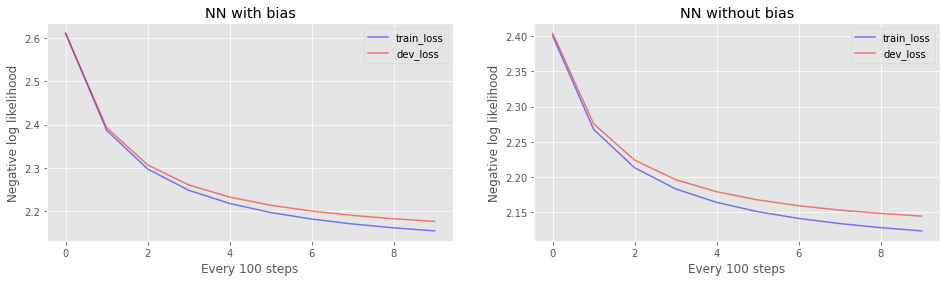

In [34]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

titles = ['NN with bias','NN without bias']

fig, axs = plt.subplots(1,2,figsize=(16, 4))

for idx,ax in enumerate(axs):
    ax.plot(range(steps+1), train_ls[idx], alpha=0.5, color='blue', label='train_loss')
    ax.plot(range(steps+1), dev_ls[idx], alpha=0.5, color='red', label='dev_loss')
    ax.legend(loc='best')
    ax.set_ylabel("Negative log likelihood")
    ax.set_xlabel("Every 100 steps")
    ax.set_title(titles[idx])

plt.show()

In [35]:
# compute test loss with our model with L2 regularization
test_wb = nn_wb.evaluate(X_test, y_test)
print(f'Loss on the test set for our model with bias is {test_wb:.4f}')

test_wob = nn_wob.evaluate(X_test, y_test)
print(f'Loss on the test set for our model without bias is {test_wob:.4f}')

Loss on the test set for our model with bias is 2.1980
Loss on the test set for our model without bias is 2.1666


In [36]:
for names_wb,names_wob in zip(nn_wb.generate(),nn_wob.generate()):
    print(f'Model with bias:{names_wb} Model without bias:{names_wob}')

Model with bias:.dannayechavaniadren. Model without bias:.fen.
Model with bias:.broihaipdcbbalarainan. Model without bias:.jarrevellizailyn.
Model with bias:.gavaanson. Model without bias:.ruziyk.
Model with bias:.terlia. Model without bias:.yandinellyn.
Model with bias:.jayras. Model without bias:.chrimickiracy.
Model with bias:.do. Model without bias:.samin.
Model with bias:.faarina. Model without bias:.sabramper.
Model with bias:.airanoakaeah. Model without bias:.jaya.
Model with bias:.daviahiaarabarrah. Model without bias:.hasir.
Model with bias:.farichrola. Model without bias:.braystephgbomehter.


## 3.2 Trying ElasticNet regularization

Let's compute  till the moment, when the difference in loss between 100 steps is less then 1e-4

In [37]:
# ElasticNet regul
nn_EN = Net(ngrams=2,bias=True, regul='ElasticNet')

train_ls = []
dev_ls = []

start_loss = nn_EN.evaluate(X_test,y_test)

In [38]:
train_ls_EN,dev_ls_EN, steps = train_epoch(nn_EN,10)

train loss on 100 steps for model is 2.6116
dev loss on 100 steps for model is 2.6109
train loss on 200 steps for model is 2.3867
dev loss on 200 steps for model is 2.3928
train loss on 300 steps for model is 2.2969
dev loss on 300 steps for model is 2.3065
train loss on 400 steps for model is 2.2478
dev loss on 400 steps for model is 2.2602
train loss on 500 steps for model is 2.2171
dev loss on 500 steps for model is 2.2319
train loss on 600 steps for model is 2.1961
dev loss on 600 steps for model is 2.2129
train loss on 700 steps for model is 2.1809
dev loss on 700 steps for model is 2.1994
train loss on 800 steps for model is 2.1694
dev loss on 800 steps for model is 2.1893
train loss on 900 steps for model is 2.1605
dev loss on 900 steps for model is 2.1815
train loss on 1000 steps for model is 2.1533
dev loss on 1000 steps for model is 2.1754
learining rate is changed to 40
Model model dev_loss is 2.1754


In [39]:
#as we can see, ElasticNet regularization a bit better

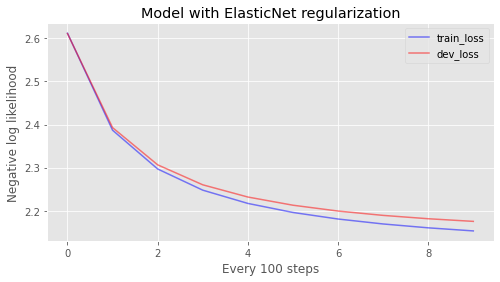

In [40]:
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(steps+1), train_ls_EN, alpha=0.5, color='blue', label='train_loss')
ax.plot(range(steps+1), dev_ls_EN, alpha=0.5, color='red', label='dev_loss')
ax.legend(loc='best')
ax.set_ylabel("Negative log likelihood")
ax.set_xlabel("Every 100 steps")
ax.set_title('Model with ElasticNet regularization')

plt.show()

In [41]:
test_EN_loss = nn_EN.evaluate(X_test, y_test)
print(f'Test loss before fine-tuning is {start_loss:.4f}')
print(f'Test loss after fine-tuning regularization is {test_EN_loss:.4f}')

Test loss before fine-tuning is 4.8236
Test loss after fine-tuning regularization is 2.1979


In [42]:
#cheking generated names
for names in nn_EN.generate():
    print(names)

.dannayechavaniadren.
.broihaipdcbbalarainan.
.gavaanson.
.terlia.
.jayras.
.do.
.faarina.
.airanoakaeah.
.daviahiaarabarrah.
.farichrola.


Train set achieving less loss due to fitting on train distribution , while  dev and test sets distributions slightly different. At some moment, dev set loss will stop changing and that's the point when model gets to overfitting zone.

Best achieved loss is 2.1588 (It might be better, but loss already pretty close to the limit)

In next section with faster model we might get better result.

# Exercise 4&5.

Ex 4. We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

Ex 5. Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [43]:
#(Len(dataset), 729) @ (729, 27) = (Len(dataset), 27) instead of 729 one-hot we can use row with number of current element
# we can store the right row for current bigram
# we should:
# compute the bigram number
# take that row into logits (didn't work)
# simply create new tensor by this way: w[x] w-weight matrix, x - train set (worked)

In [44]:
# To change nll loss to cross_entropy loss we should:
# don't log our probabilities, feed row logits to the cross_entropy loss

In [45]:
# we cannot use in-place operation in requires_grad tensor, but we can rearange the matrix by the rows
#checking how backpropagation in torch is working
logits = torch.zeros((2,3))
example =torch.tensor([[1.0, 2.0, 3.0], [4.5, 5.5, 6.6]], requires_grad = True)
print(logits)
# for i in range(xs.nelement()):
#     logits[i] = example[xs[i].item()]
logits[0] += torch.tensor([1.0,3.0,4.0],requires_grad= True)
logits[1] += torch.tensor([4.9,5.6,1.3], requires_grad = True)
print(logits)
counts = logits.exp()
print(counts)
probs = counts / counts.sum(1, keepdims=True)
print(probs)
test = -probs.log().mean()

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1.0000, 3.0000, 4.0000],
        [4.9000, 5.6000, 1.3000]], grad_fn=<CopySlices>)
tensor([[  2.7183,  20.0855,  54.5981],
        [134.2898, 270.4264,   3.6693]], grad_fn=<ExpBackward0>)
tensor([[0.0351, 0.2595, 0.7054],
        [0.3288, 0.6622, 0.0090]], grad_fn=<DivBackward0>)


In [46]:
#compute softmax by formula and using torch function
inp = torch.randn(3, 5, requires_grad=True)
print(inp)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
handed_softmax = inp.exp()
handed_softmax = handed_softmax/handed_softmax.sum(1, keepdim=True)
print(handed_softmax)
print(F.softmax(inp, dim=1))
#check the inputs of nll_loss func
output = F.nll_loss(F.log_softmax(inp, dim=1), target) # log logits and targets
print(output)
output.backward()
print(inp.grad)

tensor([[ 0.0238, -1.2784,  0.8397, -0.9924,  0.0563],
        [-0.8394, -0.5662,  1.3886, -0.7278,  0.7246],
        [-0.7902, -0.4120,  0.6148,  1.7663,  0.1429]], requires_grad=True)
tensor([[0.2029, 0.0552, 0.4588, 0.0734, 0.2096],
        [0.0572, 0.0751, 0.5306, 0.0639, 0.2732],
        [0.0455, 0.0664, 0.1855, 0.5868, 0.1157]], grad_fn=<DivBackward0>)
tensor([[0.2029, 0.0552, 0.4588, 0.0734, 0.2096],
        [0.0572, 0.0751, 0.5306, 0.0639, 0.2732],
        [0.0455, 0.0664, 0.1855, 0.5868, 0.1157]], grad_fn=<SoftmaxBackward0>)
tensor(2.6385, grad_fn=<NllLossBackward0>)
tensor([[ 0.0676, -0.3149,  0.1529,  0.0245,  0.0699],
        [-0.3143,  0.0250,  0.1769,  0.0213,  0.0911],
        [ 0.0152,  0.0221,  0.0618,  0.1956, -0.2948]])


In [47]:
#creating model class with support of nll_loss and cross_entropy loss


class Net_without_one_hot():
    def __init__(self, ngrams,gen = None, bias = True,lr = 50, regul = 'L2', lamb = 0.01, name = "model", loss = F.nll_loss):
        self.ngrams = int(pow(27,ngrams))
        self.out = 27 # vocab_size
        self.lr = lr
        self.lamb = lamb
        self.reg = regs[regul]
        self.name = name
        
        self.loss = loss
        
        if not gen:
            self.gen = torch.Generator().manual_seed(2148483647)
        else:
            self.gen = gen    
        self.W = torch.randn((self.ngrams, self.out), generator= self.gen, requires_grad=True)
        self.bias = bias
        if bias:
            self.b = torch.randn((self.out), generator = self.gen, requires_grad=True)
            

    def train(self, xs, ys, steps=100):
        
        for k in range(steps):
  
            # forward pass
    
            #softmax
            if self.loss == F.nll_loss:
                logits = F.log_softmax(self.W[xs]+self.b, dim = 1)
            elif self.loss == F.cross_entropy:
                logits = self.W[xs]+self.b
            #-------
            
            loss = self.loss(logits, ys) + self.reg(self.W, self.lamb)# input : logits after softmax
            # backward pass
            self.W.grad = None # set to zero the gradient
            loss.backward()
            
            # update
            self.W.data += -self.lr * self.W.grad
            
            
        return logits, loss.item()
            
    def evaluate(self,xs,ys):
         
        if self.loss == F.nll_loss:
            logits = F.log_softmax(self.W[xs], dim = 1) # we should incert bias ande softmax
        elif self.loss == F.cross_entropy:
            logits = self.W[xs] + self.b

        loss = self.loss(logits,ys) + self.reg(self.W, self.lamb)
        return loss.item()
        
    def generate(self,number=10):
        # finally, sample from the 'neural net' model
        outs = []
        for i in range(number):
            out = []
            ix = 0
            while True:
                if not out:
                    p = P_first
                    ix = 0
                    # we don't need .. starting point
                    while ix==0:
                        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=self.gen).item()
                    out.append(itob[ix])
                    ix = ix
                else:             
                    p = F.softmax(self.W[ix:ix+1], dim =1)
                    #getting last char
                    prev_char = itob[ix][-1]
                    #generate next char
                    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=self.gen).item()
                    #current char
                    cur_char = itoc[ix]
                    out.append(cur_char)
                    # check if it's dot
                    if ix==0:
                        break
                    #create next ix  (take second char of last bigramc 'prev_char' and concat with current 'cur_char')
                    ix = btoi[prev_char+cur_char]
                if ix == 0:
                    break

            outs.append(''.join(out))
        return outs         

In [48]:
nn_test = Net_without_one_hot(2,
#                               lr=10,
                              loss= F.cross_entropy
                             )

In [49]:
# it's good idea to stop model, when loss change became too small
train_ls, dev_ls, stes = train_epoch(nn_test,30,10)

train loss on 100 steps for model is 2.6115
dev loss on 100 steps for model is 2.6108
train loss on 200 steps for model is 2.3867
dev loss on 200 steps for model is 2.3927
train loss on 300 steps for model is 2.2968
dev loss on 300 steps for model is 2.3065
train loss on 400 steps for model is 2.2478
dev loss on 400 steps for model is 2.2602
train loss on 500 steps for model is 2.2170
dev loss on 500 steps for model is 2.2319
train loss on 600 steps for model is 2.1961
dev loss on 600 steps for model is 2.2129
train loss on 700 steps for model is 2.1809
dev loss on 700 steps for model is 2.1994
train loss on 800 steps for model is 2.1695
dev loss on 800 steps for model is 2.1894
train loss on 900 steps for model is 2.1606
dev loss on 900 steps for model is 2.1816
train loss on 1000 steps for model is 2.1534
dev loss on 1000 steps for model is 2.1755
learining rate is changed to 40
train loss on 1100 steps for model is 2.1486
dev loss on 1100 steps for model is 2.1715
train loss on 1200

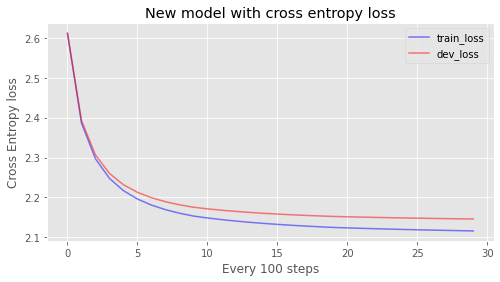

In [50]:
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(stes+1), train_ls, alpha=0.5, color='blue', label='train_loss')
ax.plot(range(stes+1), dev_ls, alpha=0.5, color='red', label='dev_loss')
ax.legend(loc='best')
ax.set_ylabel("Cross Entropy loss")
ax.set_xlabel("Every 100 steps")
ax.set_title('New model with cross entropy loss')

plt.show()

In [51]:
print(nn_test.evaluate(X_test, y_test))

2.167217254638672


In [52]:
nn_test.b

tensor([-0.2381, -1.7644, -0.2462, -0.4660, -1.1738, -0.6558,  1.8413,  2.5684,
        -0.5460, -1.3377,  0.1933, -0.1804,  0.7121,  1.1720, -0.8756, -1.1916,
         0.6587,  1.0301, -1.0300, -0.2580,  0.6532,  0.2315, -0.5518, -0.8049,
         0.8123,  0.2672,  0.2013], requires_grad=True)

In [53]:
for names in nn_test.generate():
    print(names)

.dannayechavaniaconi.
.broie.
.fia.
.ba.
.ini.
.nean.
.gavaanson.
.terlia.
.jayras.
.do.


Bias increases loss, but generated names feels more natural(we don't see many consonants in a row). My hypothesis is bias gives general distribution to vowels and make them appear more often.

After changing F.one_hot to indexing number of rows, our dev and test loss increased, but we significantly increased the computation speed 

When we compute cross entropy loss, we do not log our logits as in nll_loss, so it's slightly decreasing computation resoures needed

# Additional. Time differences between vanila model and modified model.

In [54]:
import time

In [55]:
nn_old = Net(2)

nn_new_ce = Net_without_one_hot(2, loss = F.cross_entropy)

nn_new_nll = Net_without_one_hot(2)

In [56]:
%%time

train_ls, dev_ls, stes = train_epoch(nn_old,1,10)

train loss on 100 steps for model is 2.4005
dev loss on 100 steps for model is 2.4040
Model model dev_loss is 2.4040
CPU times: total: 7min 12s
Wall time: 1min 16s


In [57]:
%%time

train_ls, dev_ls, stes = train_epoch(nn_new_nll,1,10)

train loss on 100 steps for model is 2.6115
dev loss on 100 steps for model is 2.5136
Model model dev_loss is 2.5136
CPU times: total: 34.6 s
Wall time: 6.03 s


In [58]:
%%time
train_ls, dev_ls, stes = train_epoch(nn_new_ce,1,10)

train loss on 100 steps for model is 2.6115
dev loss on 100 steps for model is 2.6108
Model model dev_loss is 2.6108
CPU times: total: 35.7 s
Wall time: 6.05 s


As we can see, using cross entropy loss significantly improve computation speed. We need more steps to train our model, but it's stil will be faster. I also use softmax function from pytorch instead of formulas, the computation speed of nll increased too.